In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM
from scipy import stats


In [2]:
df = pd.read_csv(r'C:\Users\sreej\Downloads\midterm_partone.csv')

In [3]:
df.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Constant            1696 non-null   int64  
 1   Stock Change        1696 non-null   float64
 2   Inventory Turnover  1696 non-null   float64
 3   Operating Profit    1696 non-null   float64
 4   Interaction Effect  1696 non-null   float64
 5   Current Ratio       1696 non-null   float64
 6   Quick Ratio         1696 non-null   float64
 7   Debt Asset Ratio    1696 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 106.1 KB


In [5]:
# Define and fit initial IV model
model_iv = sm.OLS(df["Inventory Turnover"], df[["Constant", "Current Ratio", "Quick Ratio", "Debt Asset Ratio"]]).fit()
endog_predict = model_iv.predict(df[["Constant", "Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])
df["Endogenous Param"] = endog_predict


In [6]:
# Define dependent, independent, and instrument variables
y_vals = np.array(df["Stock Change"])
x_vals = np.array(df[["Inventory Turnover", "Operating Profit", "Interaction Effect"]])
iv_vals = np.array(df[["Current Ratio", "Quick Ratio", "Debt Asset Ratio"]])

In [8]:
model_2sls = sm.OLS(df["Stock Change"], df[["Constant","Endogenous Param",\
                                                              "Operating Profit","Interaction Effect",\
                                                             ]]).fit()
model_2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           1.27e-05
Time:                        16:10:39   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0.020     -0.896      0.370      -0.056       0.021
Endogenous Param       0.0011      0.001      1.827      0.068   -7.76e-05       0.002
Operating Profit      -0.1201      0.028     -4.319      0.000      -0.175      -0.066
Interaction Effect     0.0014      0.000      3.621      0.000       0.001       0.002
==============================================================================
Omnibus:                      368.832   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3433.920
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                       9.811   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 = params
        endog = self.endog
        exog = self.exog
        inst = self.instrument   

        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] 
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] 
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] 

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1])
res = gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, k_moms=6, k_params=4).fit(beta0)

res.summary()

Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 8
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.000373
         Iterations: 7
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 5
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000372
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 gmm Results                                  
==============================================================================
Dep. Variable:                      y   Hansen J:                       0.6317
Model:                            gmm   Prob (Hansen J):                 0.729
Method:                           GMM                                         
Date:                Wed, 06 Nov 2024                                         
Time:                        16:11:29                                         
No. Observations:                1696                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0           -0.0200      0.021     -0.964      0.335      -0.061       0.021
p 1            0.0011      0.001      1.843      0.065   -6.89e-05       0.002
p 2           -0.1071      0.032     -3.370      0.001      -0.169      -0.045
p 3            0.0011      0.000      2.760      0.006       0.000       0.002
==============================================================================
"""

In [11]:
y_vals  = np.array(df["Stock Change"])
x_vals  = np.array(df[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(df[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

In [12]:
# Define GMM model with delta term
class GMMModelWithBias(GMM):
    def momcond(self, params):
        p0, p1, p2, p3, delta = params  # Adding delta for bias term
        endog = self.endog
        exog = self.exog
        inst = self.instrument

        # Modify moment conditions to include delta in instrument terms
        error0 = endog - p0 - p1 * exog[:, 0] - p2 * exog[:, 1] - p3 * exog[:, 2]
        error1 = error0 * exog[:, 1]
        error2 = error0 * exog[:, 2]
        error3 = (error0 * inst[:, 0]) - delta
        error4 = (error0 * inst[:, 1]) - delta
        error5 = (error0 * inst[:, 2]) - delta

        return np.column_stack((error0, error1, error2, error3, error4, error5))

In [ ]:
# Initial parameters
beta0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
gmm_model = GMMModelWithBias(endog=y_vals, exog=x_vals, instrument=iv_vals, k_moms=6, k_params=5)
gmm_result = gmm_model.fit(beta0)

# Print summary of results
print(gmm_result.summary())

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
                           GMMModelWithBias Results                           
Dep. Variable:                      y   Hansen J:                       0.5862
Model:               GMMModelWithBias   Prob (Hansen J):                 0.444
Method:                           GMM                                         
D

Statistical Significance of Delta (p4):

The p-value for p4 (delta term) is 0.831, which is well above the typical significance threshold of 0.05. This suggests that the delta term does not significantly contribute to the model, supporting the conclusion that the expert’s bias claim is statistically unjustified.
Interpretation of Other Parameters:

Other parameters (p2, p3) are statistically significant (with p-values < 0.05). This implies that factors like Operating Profit and Interaction Effect are relevant predictors in the model.
Hansen J Test:

The Hansen J test p-value is 0.444, which is also above the 0.05 threshold, suggesting that the instruments used in the model are valid and appropriately address endogeneity.

In [15]:
coefficients = gmm_result.params
delta_coefficient = coefficients[4]
delta_std_err = gmm_result.bse[4] 
nobs = gmm_result.nobs
num_coef = len(coefficients)
df = nobs - num_coef
alpha = 0.05
t_statistic = delta_coefficient / delta_std_err
critical_t_value = stats.t.ppf(1 - alpha / 2, df)
p_value = gmm_result.wald_test(r_matrix=np.array([0, 0, 0, 0, 1])).pvalue
if abs(t_statistic) > critical_t_value:
    print(f"Delta coefficient (p4) is statistically significant (p-value = {p_value}), reject the null hypothesis.")
else:
    print(f"Delta coefficient (p4) is not statistically significant (p-value = {p_value}), fail to reject the null hypothesis.")

Delta coefficient (p4) is not statistically significant (p-value = 0.8310101210019929), fail to reject the null hypothesis.


C:\Users\sreej\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Part 2

In [18]:
df = pd.read_csv(r'C:\Users\sreej\Downloads\midterm_parttwo.csv')

In [19]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [20]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for Years of Education after High School: [1 2 3 7 4 5 0 6]
Unique values for Requested Credit Amount: ['Low' 'Medium' 'High']
Unique values for Number of Dependents: ['No dependent' 'Less than 2' 'More than 2']
Unique values for Monthly Income: ['Very low' 'Low' 'Moderate' 'High' 'Very High']
Unique values for Monthly Expense: ['Very low' 'Low' 'Moderate' 'High' 'Very high']
Unique values for Marital Status: ['Married' 'Single' 'Not specified']
Unique values for Credit Rating: ['Positive' 'Negative']


In [21]:
# Map categorical variables
df['Requested Credit Amount'] = df['Requested Credit Amount'].map({'Low': 1, 'Medium': 2, 'High': 3})
df['Number of Dependents'] = df['Number of Dependents'].map({'No dependent': 1, 'Less than 2': 2, 'More than 2': 3})
df['Monthly Income'] = df['Monthly Income'].map({'Very low': 1, 'Low': 2, 'Moderate': 3, 'High': 4, 'Very High': 5})
df['Monthly Expense'] = df['Monthly Expense'].map({'Very low': 1, 'Low': 2, 'Moderate': 3, 'High': 4, 'Very high': 5})
df['Marital Status'] = df['Marital Status'].map({'Married': 1, 'Single': 2, 'Not specified': 3})
df['Credit Rating'] = df['Credit Rating'].map({'Positive': 1, 'Negative': 0})

In [31]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for Years of Education after High School: [1 2 3 7 4 5 0 6]
Unique values for Requested Credit Amount: [1 2 3]
Unique values for Number of Dependents: [1 2 3]
Unique values for Monthly Income: [1 2 3 4 5]
Unique values for Monthly Expense: [1 2 3 4 5]
Unique values for Marital Status: [1 2 3]
Unique values for Credit Rating: [1 0]


In [33]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,1,1,1,1,1,1
1,2,1,1,1,1,2,1
2,1,1,1,1,1,2,1
3,3,1,1,1,1,1,1
4,3,1,1,1,1,2,0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report


In [35]:
# Separate features and target
X = df.drop('Credit Rating', axis=1)
y = df['Credit Rating']


In [36]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train logistic regression model
logreg_model = LogisticRegression(class_weight='balanced')  # Handling class imbalance
logreg_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [25]:
# Predict on test set
y_pred = logreg_model.predict(X_test)

# Evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 280  297]
 [1472 1992]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.49      0.24       577
           1       0.87      0.58      0.69      3464

    accuracy                           0.56      4041
   macro avg       0.52      0.53      0.47      4041
weighted avg       0.77      0.56      0.63      4041



he model successfully identifies 1992 positive cases as positive but also misclassifies a significant number of negative cases as positive (1472), which lowers the recall for the negative class.

Interpretation:

The precision for the positive class (class 1) is high at 0.87, meaning when the model predicts a positive outcome, it's likely correct 87% of the time.
However, recall for the positive class is moderate at 0.58, meaning that it correctly identifies only 58% of actual positive cases.
For the negative class (class 0), the model has low precision (0.16), which reflects a high rate of false positives, as it struggles to accurately identify negatives.

In [26]:
# Predict probabilities
y_probs = logreg_model.predict_proba(X_test)[:, 1]


In [27]:
# Calculate threshold for 15% approval rate
desired_approval_rate = 0.15
threshold = sorted(y_probs)[int((1 - desired_approval_rate) * len(y_probs))]

In [28]:
# Update predictions with new threshold
y_pred_updated = (y_probs >= threshold).astype(int)

In [29]:
# Updated evaluation metrics
print("Updated Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_updated))
print("\nUpdated Classification Report:")
print(classification_report(y_test, y_pred_updated))

Updated Confusion Matrix:
[[ 498   79]
 [2925  539]]

Updated Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.86      0.25       577
           1       0.87      0.16      0.26      3464

    accuracy                           0.26      4041
   macro avg       0.51      0.51      0.26      4041
weighted avg       0.77      0.26      0.26      4041



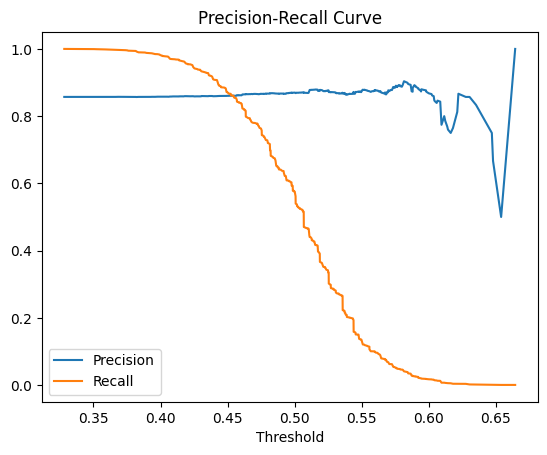

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
